In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator
mpl.rcParams['pdf.fonttype'] = 42  # edit-able in illustrator
mpl.rcParams['font.sans-serif'] = 'Arial'
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import fisher_exact

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export, stats

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
user = 'CAG'     # defines top hierarchy of output folder
outfolder = '20_tableone'    # name of notebook

def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )

In [3]:
data = pd.read_csv(
    inout.get_material_path('general/02_recode_transplants/02data-external_220920_1553.csv.gz'), 
    index_col=0)

In [4]:
dem = data.drop_duplicates(subset='Patient_id')

In [5]:
dem.shape

(585, 72)

# TableOne

In [6]:
from tableone import TableOne, load_dataset

In [7]:
mytable = TableOne(dem, columns=['Age', 'Ethnicity', 'Gender', 'Race', 'Smoking_status',
       'BMI', 'Admit_APS_score','Admit_SOFA_score', 'Cumulative_ICU_days',
       'Number_of_ICU_stays', 'Tracheostomy_flag',
       'Cumulative_intubation_days','Discharge_disposition'], categorical=['Ethnicity', 'Gender', 'Race', 'Smoking_status',
       'Tracheostomy_flag','Discharge_disposition'], nonnormal=['Age',  'BMI', 'Admit_APS_score','Admit_SOFA_score', 'Cumulative_ICU_days',
       'Number_of_ICU_stays',  'Cumulative_intubation_days'],
                   groupby='Patient_category')

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq

In [8]:
print(mytable.tabulate(tablefmt="github"))

|                                            |                         | Missing   | Overall           | COVID-19          | Non-Pneumonia Control   | Other Pneumonia   | Other Viral Pneumonia   |
|--------------------------------------------|-------------------------|-----------|-------------------|-------------------|-------------------------|-------------------|-------------------------|
| n                                          |                         |           | 585               | 190               | 93                      | 252               | 50                      |
| Age, median [Q1,Q3]                        |                         | 0         | 62.0 [51.0,72.0]  | 61.0 [51.0,70.0]  | 60.0 [49.0,70.0]        | 65.0 [52.0,73.0]  | 59.5 [52.2,69.8]        |
| Ethnicity, n (%)                           | Hispanic or Latino      | 0         | 113 (19.3)        | 69 (36.3)         | 11 (11.8)               | 22 (8.7)          | 11 (22.0)               |
|              

In [9]:
mytable.to_excel('tableone9-20-22.xlsx')

# FigureOne

In [8]:
#put everything in order

dem.Discharge_disposition = dem.Discharge_disposition.astype("category")

dem.Discharge_disposition = dem.Discharge_disposition.cat.reorder_categories([
    'Home',
    'Rehab', 
    'SNF',
    'LTACH',
    'Hospice',
    'Died'
])

Discharge_palette = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

# set categorical order
dem['Patient_category'] = pd.Categorical(dem['Patient_category'],
                                   categories=['Non-Pneumonia Control', 'Other Pneumonia', 'Other Viral Pneumonia', 'COVID-19'],
                                   ordered=True)


Category_palette = [
    "tab:gray",
    "tab:blue",
    "forestgreen",
    "crimson",
]

/var/folders/1z/56frjt7x07l1yhz_hksrdcbm7wmsv2/T/ipykernel_89212/3396299370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dem.Discharge_disposition = dem.Discharge_disposition.astype("category")
/var/folders/1z/56frjt7x07l1yhz_hksrdcbm7wmsv2/T/ipykernel_89212/3396299370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dem.Discharge_disposition = dem.Discharge_disposition.cat.reorder_categories([
/var/folders/1z/56frjt7x07l1yhz_hksrdcbm7wmsv2/T/ipykernel_89212/3396299370.py:24: SettingWithCopyWarnin

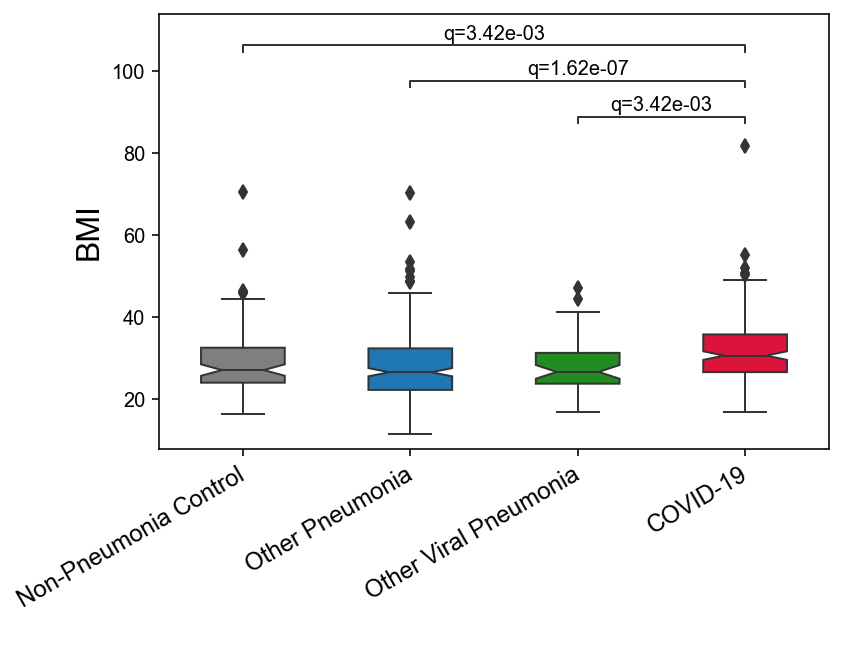

In [9]:
#example subplot
mpl.rcParams["figure.figsize"] = (6, 4)
stats_results = []


for d1, d2 in itertools.combinations(dem.Patient_category.unique(), 2):
        days1 = dem.BMI[dem.Patient_category==d1].dropna()
        days2 = dem.BMI[dem.Patient_category==d2].dropna()
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stats_results.append([d1, d2, days1.size, days2.size, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))

fig, ax = plt.subplots()
        
sns.boxplot(
    data=dem, 
    x="Patient_category",
    y="BMI", 
    ax=ax, 
    saturation=1, 
    palette = Category_palette,
    linewidth=1,
    width=0.5,
    notch=True,
    showfliers = True
)

ax.tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
ax.set_ylabel("BMI", size=16)
ax.set_xlabel(" ", size=16)
for t in ax.get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)

annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=dem, 
    x="Patient_category",
    y="BMI", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

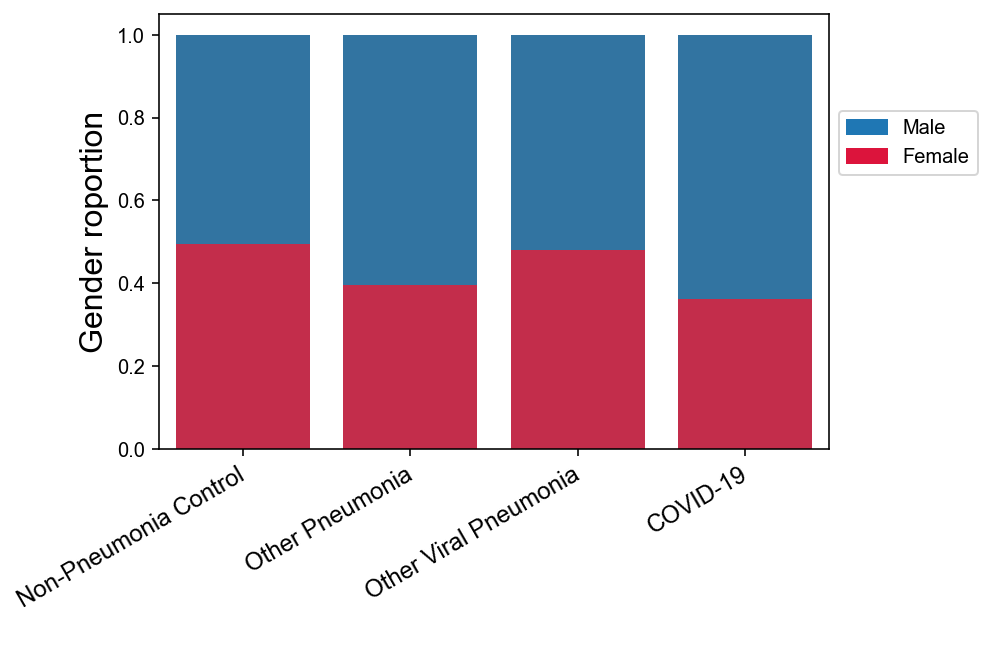

In [9]:
gender=dem.groupby(['Patient_category', 'Gender']).size().reset_index().pivot(columns='Gender', index='Patient_category', values=0).reset_index()
gender['percent_female']=gender['Female']/(gender['Female']+gender['Male'])
gender['total']=1
# gender

# set categorical order
gender['Patient_category'] = pd.Categorical(gender['Patient_category'],
                                   categories=['Non-Pneumonia Control', 'Other Pneumonia', 'Other Viral Pneumonia', 'COVID-19'],
                                   ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))
bar1 = sns.barplot(x="Patient_category",  y="total", data=gender, color='tab:blue')
bar2 = sns.barplot(x="Patient_category", y="percent_female", data=gender, color='crimson')

top_bar = mpatches.Patch(color='tab:blue', label='Male')
bottom_bar = mpatches.Patch(color='crimson', label='Female')
plt.legend(handles=[top_bar, bottom_bar])
ax.legend_.set_bbox_to_anchor((1, 0.8))

ax.set_ylabel("Gender roportion", size=16)
ax.set_xlabel(" ", size=16)


ax.tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)

In [10]:
#Gender stats
stats_results = []

for d1, d2 in itertools.combinations(gender.Patient_category.unique(), 2):
        female1 = gender.Female[gender.Patient_category==d1].values[0]
        female2 = gender.Female[gender.Patient_category==d2].values[0]
        male1 = gender.Male[gender.Patient_category==d1].values[0]
        male2 = gender.Male[gender.Patient_category==d2].values[0]

        odds, pval = fisher_exact( [(female1,male1),(female2,male2)]         
        )
        stats_results.append([d1, d2, pval])
        
stats_results

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2","pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))

stats_results

,group1,group2,pval,pval_adj
0,Non-Pneumonia Control,Other Pneumonia,0.111462,0.288324
1,Non-Pneumonia Control,Other Viral Pneumonia,1.000000,1.000000
2,Non-Pneumonia Control,COVID-19,0.039556,0.237339
3,Other Pneumonia,Other Viral Pneumonia,0.276275,0.414413
4,Other Pneumonia,COVID-19,0.490140,0.588168
5,Other Viral Pneumonia,COVID-19,0.144162,0.288324


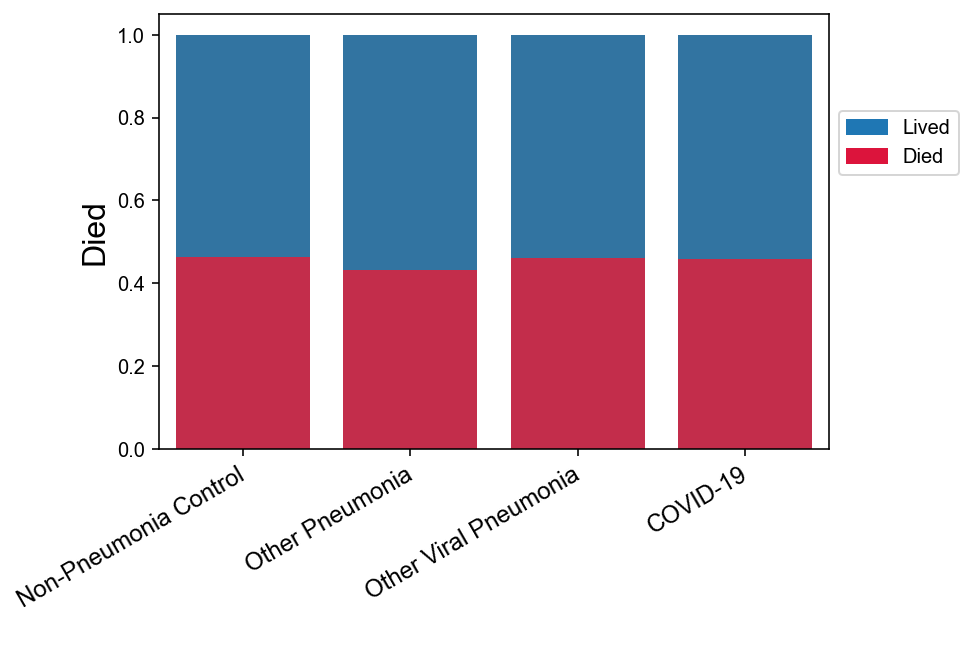

In [11]:
# dem.groupby(['Patient_category', 'Binary_outcome']).size().reset_index().pivot(columns='Binary_outcome', index='Patient_category', values=0).reset_index()
died = dem.groupby(['Patient_category', 'Binary_outcome']).size().reset_index().pivot(columns='Binary_outcome', index='Patient_category', values=0).reset_index()
died['percent_died']=died[1]/(died[1]+died[0])
died['total']=1
# died

# set categorical order
died['Patient_category'] = pd.Categorical(died['Patient_category'],
                                   categories=['Non-Pneumonia Control', 'Other Pneumonia', 'Other Viral Pneumonia', 'COVID-19'],
                                   ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))
bar1 = sns.barplot(x="Patient_category",  y="total", data=died, color='tab:blue')
bar2 = sns.barplot(x="Patient_category", y="percent_died", data=died, color='crimson')

top_bar = mpatches.Patch(color='tab:blue', label='Lived')
bottom_bar = mpatches.Patch(color='crimson', label='Died')
plt.legend(handles=[top_bar, bottom_bar])
ax.legend_.set_bbox_to_anchor((1, 0.8))

ax.set_ylabel("Died", size=16)
ax.set_xlabel(" ", size=16)

ax.tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)

In [12]:
stats.stats_results_categorical_fisher(died)

([],
 Empty DataFrame
 Columns: [group1, group2, pval, pval_adj]
 Index: [])

In [13]:
#died stats

stats_results = []

for d1, d2 in itertools.combinations(died.Patient_category.unique(), 2):
        alive1 = died[0][died.Patient_category==d1].values[0]
        alive2 = died[0][died.Patient_category==d2].values[0]
        death1 = died[1][died.Patient_category==d1].values[0]
        death2 = died[1][died.Patient_category==d2].values[0]

        pval = fisher_exact([ [alive1, death1],
                                        [alive2, death2]])
        stats_results.append([d1, d2, pval])
stats_results
        

[['Non-Pneumonia Control',
  'Other Pneumonia',
  (0.8863229793462352, 0.627197213232475)],
 ['Non-Pneumonia Control', 'Other Viral Pneumonia', (0.9905254091300603, 1.0)],
 ['Non-Pneumonia Control', 'COVID-19', (0.9821630164822759, 1.0)],
 ['Other Pneumonia',
  'Other Viral Pneumonia',
  (1.1175671083927965, 0.756325179356399)],
 ['Other Pneumonia', 'COVID-19', (1.1081321813485348, 0.6291823431885777)],
 ['Other Viral Pneumonia', 'COVID-19', (0.9915576192486281, 1.0)]]

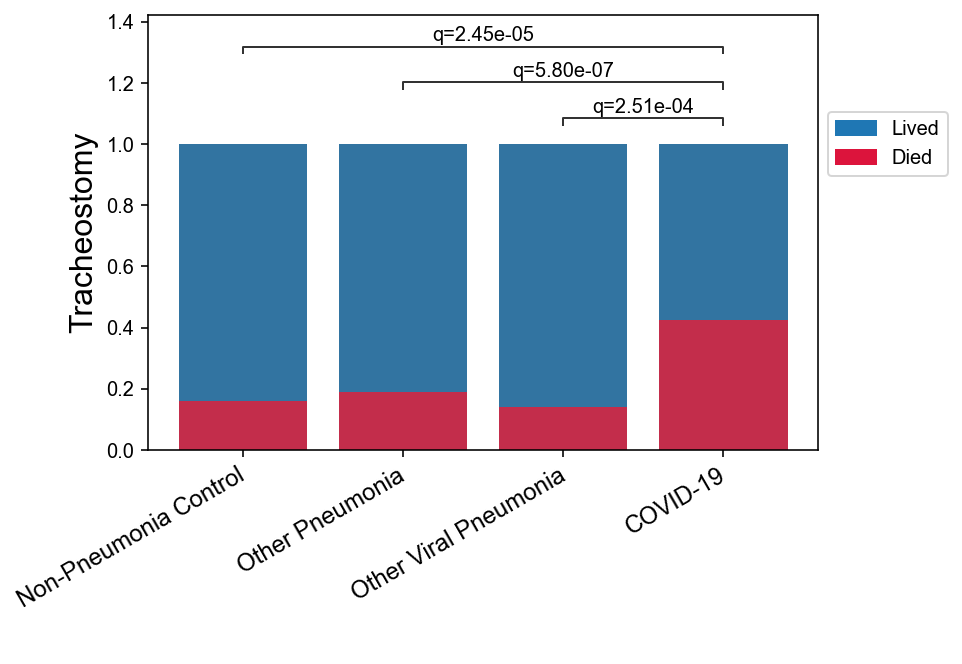

In [14]:
# dem.groupby(['Patient_category', 'Binary_outcome']).size().reset_index().pivot(columns='Binary_outcome', index='Patient_category', values=0).reset_index()
trach = dem.groupby(['Patient_category', 'Tracheostomy_flag']).size().reset_index().pivot(columns='Tracheostomy_flag', index='Patient_category', values=0).reset_index()
trach['percent_trach']=trach[1]/(trach[1]+trach[0])
trach['total']=1
# died


# stats_results = []

# for d1, d2 in itertools.combinations(trach.Patient_category.unique(), 2):
#         alive1 = trach[1][trach.Patient_category==d1].values[0]
#         alive2 = trach[1][trach.Patient_category==d2].values[0]
#         died1 = trach[0][trach.Patient_category==d1].values[0]
#         died2 = trach[0][trach.Patient_category==d2].values[0]

#         odds, pval = fisher_exact([ [alive1, died1],
#                                         [alive2, died2]])
#         stats_results.append([d1, d2, pval])  

# stats_results = pd.DataFrame(stats_results, columns=["group1", "group2","pval"])
# stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
# stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
# pairs = []
# for _, r in stat_results_sign.iterrows():
#         pairs.append((r.group1, r.group2))
# stats_results

pairs, stat_results_sign = stats.stats_results_categorical_fisher(trach)

# set categorical order
trach['Patient_category'] = pd.Categorical(trach['Patient_category'],
                                   categories=['Non-Pneumonia Control', 'Other Pneumonia', 'Other Viral Pneumonia', 'COVID-19'],
                                   ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))
bar1 = sns.barplot(x="Patient_category",  y="total", data=trach, color='tab:blue')
bar2 = sns.barplot(x="Patient_category", y="percent_trach", data=trach, color='crimson')

top_bar = mpatches.Patch(color='tab:blue', label='Lived')
bottom_bar = mpatches.Patch(color='crimson', label='Died')
plt.legend(handles=[top_bar, bottom_bar])
ax.legend_.set_bbox_to_anchor((1, 0.8))

ax.set_ylabel("Tracheostomy", size=16)
ax.set_xlabel(" ", size=16)

ax.tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)
    

annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=trach, 
    x="Patient_category",
    y="percent_trach", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

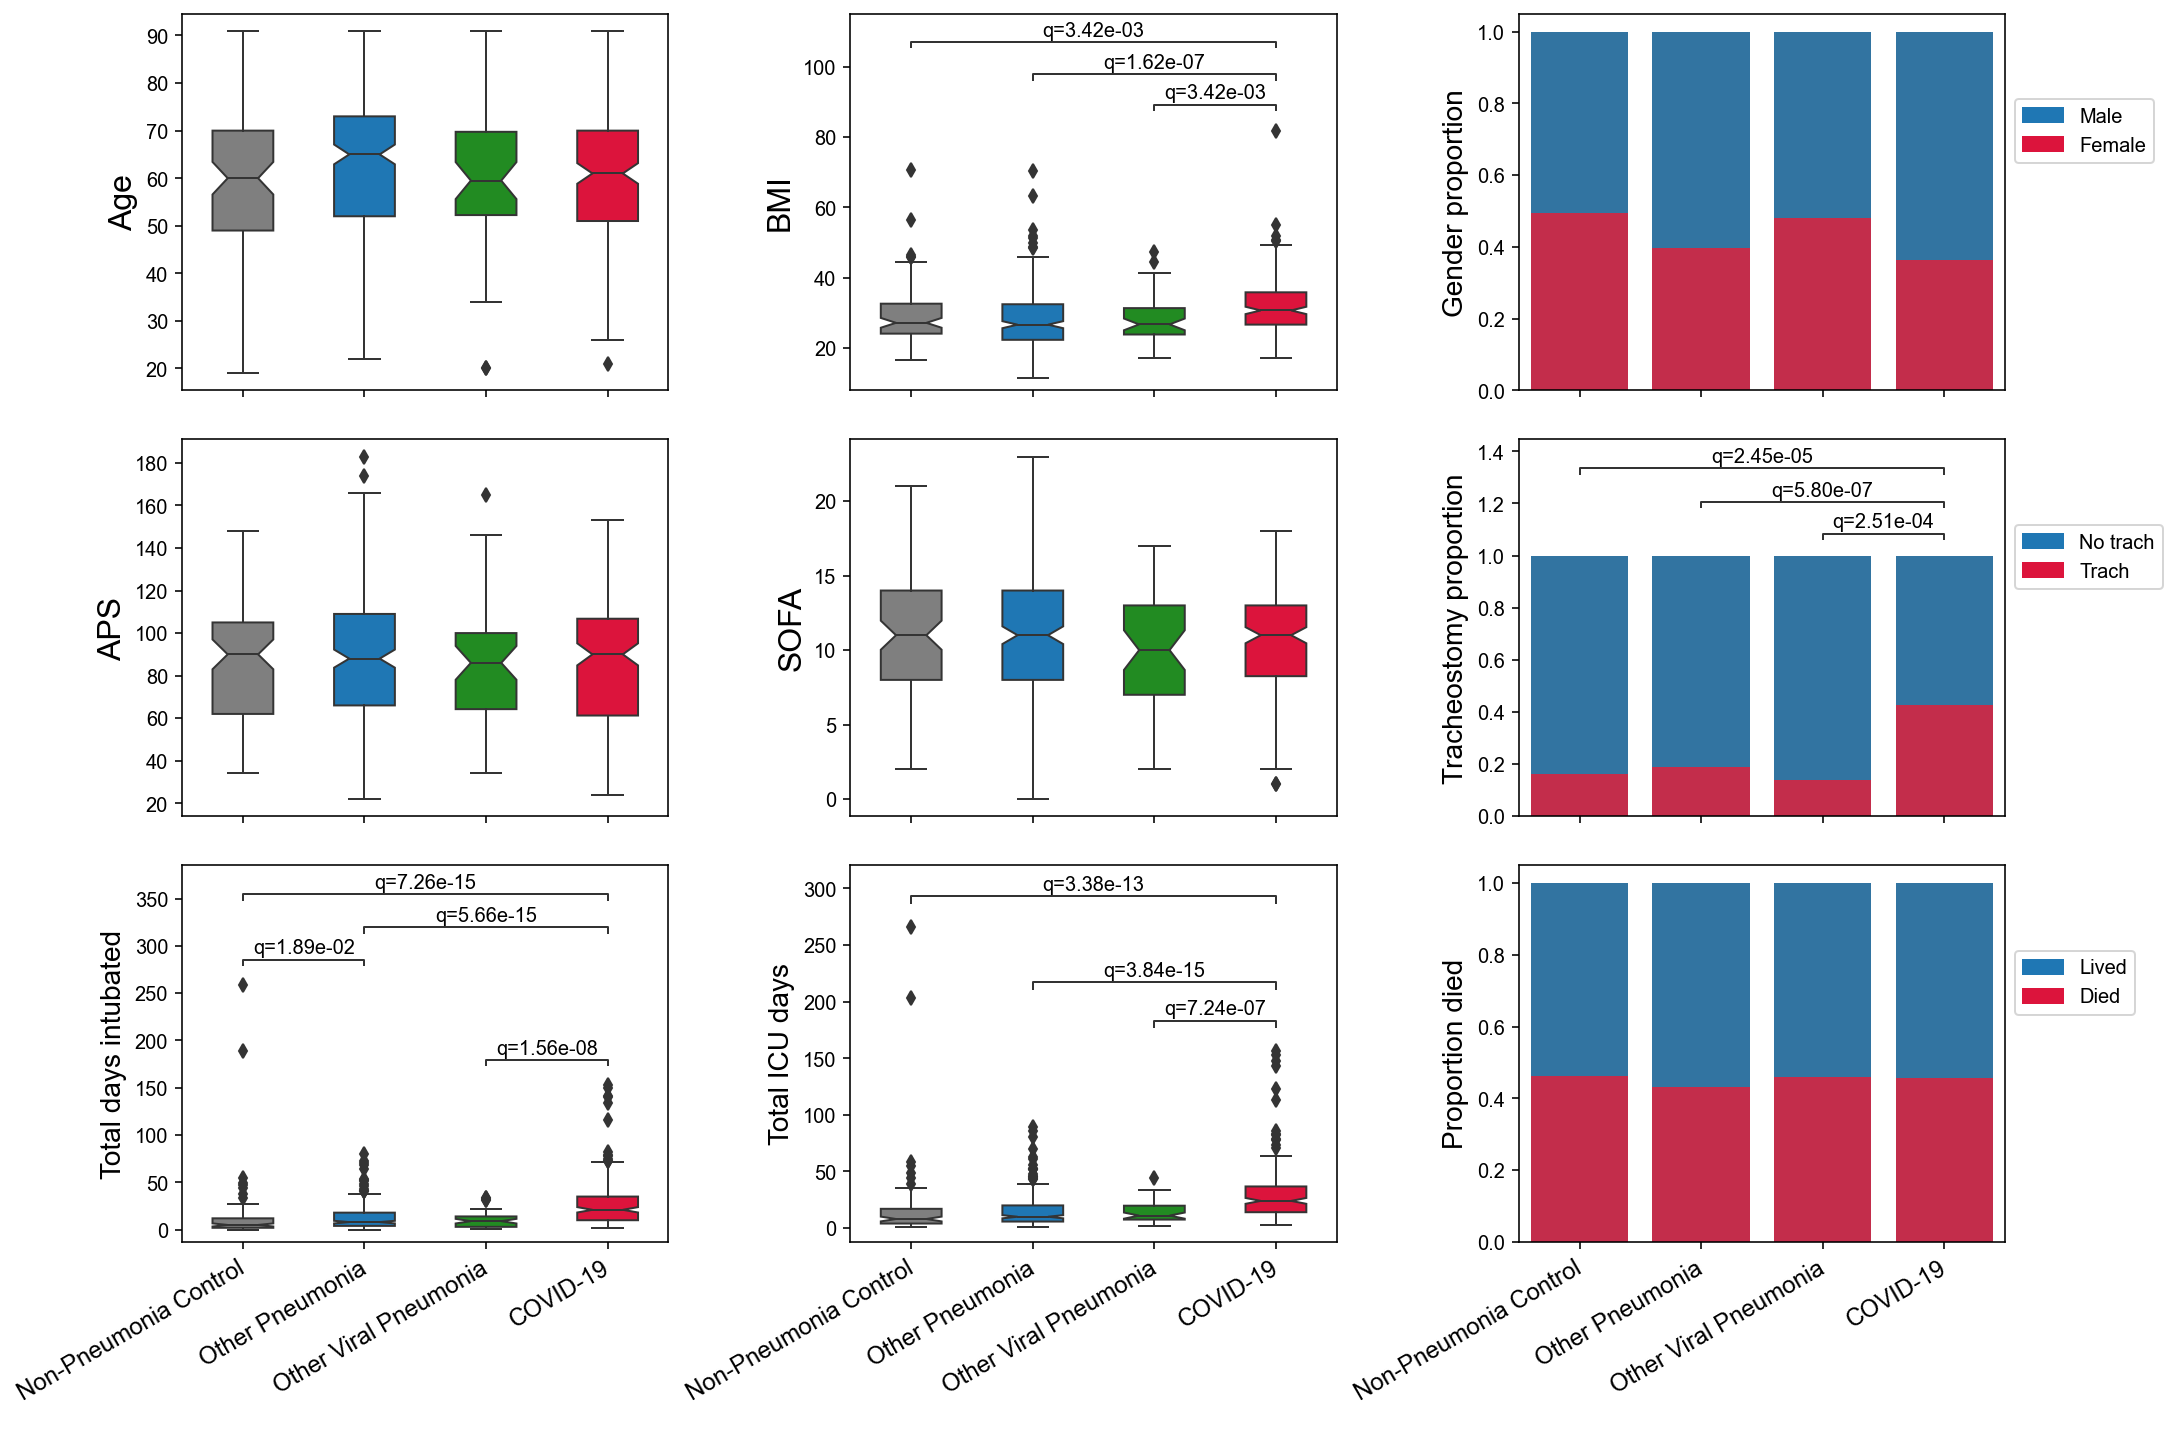

In [16]:
mpl.rcParams["figure.figsize"] = (15, 10)



fig, axs = plt.subplots(3, 3, sharex=True,constrained_layout=True)



sns.boxplot(
    data=dem, 
    x="Patient_category",
    y="Age", 
    ax=axs[0,0], 
    saturation=1, 
    palette = Category_palette,
    linewidth=1,
    width=0.5,
    notch=True,
    showfliers = True
)

axs[0,0].set_ylabel("Age", size=16)

axs[0,0].set_xlabel(" ", size=16)



stats_results = []

for d1, d2 in itertools.combinations(dem.Patient_category.unique(), 2):
        days1 = dem.BMI[dem.Patient_category==d1].dropna()
        days2 = dem.BMI[dem.Patient_category==d2].dropna()
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stats_results.append([d1, d2, days1.size, days2.size, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))

sns.boxplot(
    data=dem, 
    x="Patient_category",
    y="BMI", 
    ax=axs[0,1], 
    saturation=1, 
    palette = Category_palette,
    linewidth=1,
    width=0.5,
    notch=True,
    showfliers = True
)

axs[0,1].set_ylabel("BMI", size=16)
axs[0,1].set_xlabel(" ", size=16)


annotator = statannotations.Annotator.Annotator(
    axs[0,1], 
    pairs, 
    data=dem, 
    x="Patient_category",
    y="BMI", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();








sns.boxplot(
    data=dem, 
    x="Patient_category",
    y="Admit_APS_score", 
    ax=axs[1,0], 
    saturation=1, 
    linewidth=1,
    width=0.5,
    palette = Category_palette,
    showfliers = True,
    notch=True
)
axs[1,0].set_ylabel("APS", size=16)
axs[1,0].set_xlabel(" ", size=16)



sns.boxplot(
    data=dem, 
    x="Patient_category",
    y="Admit_SOFA_score", 
    ax=axs[1,1], 
    saturation=1, 
    linewidth=1,
    width=0.5,
    showfliers = True,
    notch=True, 
    palette = Category_palette,
)
axs[1,1].set_ylabel("SOFA", size=16)
axs[1,1].set_xlabel(" ", size=16)







stats_results = []

for d1, d2 in itertools.combinations(dem.Patient_category.unique(), 2):
        days1 = dem.Cumulative_intubation_days[dem.Patient_category==d1]
        days2 = dem.Cumulative_intubation_days[dem.Patient_category==d2]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stats_results.append([d1, d2, days1.size, days2.size, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
        

sns.boxplot(
    data=dem, 
    x="Patient_category",
    y="Cumulative_intubation_days", 
    ax=axs[2,0], 
    saturation=1, 
    linewidth=1,
    width=0.5,
    notch=True,
    palette = Category_palette,
    showfliers = True
)

axs[2,0].set_ylabel("Total days intubated", size=14)
axs[2,0].set_xlabel(" ", size=16)



annotator = statannotations.Annotator.Annotator(
    axs[2,0], 
    pairs, 
    data=dem, 
    x="Patient_category",
    y="Cumulative_intubation_days", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();


stats_results = []

for d1, d2 in itertools.combinations(dem.Patient_category.unique(), 2):
        days1 = dem.Cumulative_ICU_days[dem.Patient_category==d1]
        days2 = dem.Cumulative_ICU_days[dem.Patient_category==d2]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stats_results.append([d1, d2, days1.size, days2.size, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))

sns.boxplot(
    data=dem, 
    x="Patient_category",
    y="Cumulative_ICU_days", 
    ax=axs[2,1], 
    saturation=1, 
    linewidth=1,
    width=0.5,
    notch=True,
    showfliers = True,
    palette = Category_palette,
)

axs[2,1].set_ylabel("Total ICU days", size=14)
axs[2,1].set_xlabel(" ", size=16)


annotator = statannotations.Annotator.Annotator(
    axs[2,1], 
    pairs, 
    data=dem, 
    x="Patient_category",
    y="Cumulative_ICU_days", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();






bar3 = sns.barplot(x="Patient_category",  y="total", data=gender, color='tab:blue', ax=axs[0, 2])
bar4 = sns.barplot(x="Patient_category", y="percent_female", data=gender, color='crimson', ax=axs[0, 2])

axs[0,2].set_ylabel("Gender proportion", size=14)
axs[0,2].set_xlabel(" ", size=16)


top_bar = mpatches.Patch(color='tab:blue', label='Male')
bottom_bar = mpatches.Patch(color='crimson', label='Female')
axs[0, 2].legend(handles=[top_bar, bottom_bar])
axs[0, 2].legend_.set_bbox_to_anchor((1, 0.8))




stats_results = []

for d1, d2 in itertools.combinations(trach.Patient_category.unique(), 2):
        alive1 = trach[1][trach.Patient_category==d1].values[0]
        alive2 = trach[1][trach.Patient_category==d2].values[0]
        died1 = trach[0][trach.Patient_category==d1].values[0]
        died2 = trach[0][trach.Patient_category==d2].values[0]

        odds, pval = fisher_exact([ [alive1, died1],
                                        [alive2, died2]])
        stats_results.append([d1, d2, pval])  

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2","pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stats_results


bar1 = sns.barplot(x="Patient_category",  y="total", data=trach, color='tab:blue', ax=axs[1,2])
bar2 = sns.barplot(x="Patient_category", y="percent_trach", data=trach, color='crimson',ax=axs[1,2])

top_bar = mpatches.Patch(color='tab:blue', label='No trach')
bottom_bar = mpatches.Patch(color='crimson', label='Trach')
plt.legend(handles=[top_bar, bottom_bar])
axs[1, 2].legend(handles=[top_bar, bottom_bar])
axs[1, 2].legend_.set_bbox_to_anchor((1, 0.8))
    
axs[1,2].set_ylabel("Tracheostomy proportion", size=14)

axs[1,2].set_xlabel(" ", size=16)

annotator = statannotations.Annotator.Annotator(
    axs[1,2], 
    pairs, 
    data=trach, 
    x="Patient_category",
    y="percent_trach", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();



top_bar = mpatches.Patch(color='tab:blue', label='Lived')
bottom_bar = mpatches.Patch(color='crimson', label='Died')
axs[2, 2].legend(handles=[top_bar, bottom_bar])
axs[2, 2].legend_.set_bbox_to_anchor((1, 0.8))


bar1 = sns.barplot(x="Patient_category",  y="total", data=died, color='tab:blue', ax=axs[2, 2])
bar2 = sns.barplot(x="Patient_category", y="percent_died", data=died, color='crimson', ax=axs[2, 2])

axs[2,2].set_ylabel("Proportion died", size=14)
axs[2,2].set_xlabel(" ", size=16)



# bottom row labels

axs[2,0].tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in axs[2,0].get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)
    
    
axs[2,1].tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in axs[2,1].get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)
    
    
axs[2,2].tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in axs[2,2].get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)
    
    
    
dump_figure('figureone_005_showfliers_9-8-22.pdf')